In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [35]:
# --- 1) Carrega e reduz a 1 feature (por velocidade) ---
data = fetch_california_housing()
X = data.data[:, [0, 1]]  # MedInc
y = data.target

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)


In [37]:
graus = [i for i in range(15)]
B = 30  # número de bootstraps

bias2_vals = []
var_vals   = []

# --- 3) Loop de bootstrap para cada grau ---
for M in graus:
    # armazena as predições de cada bootstrap
    preds_boot = np.zeros((B, len(X_test)))
    
    for b in range(B):
        # amostra bootstrap
        Xb, yb = resample(X_train, y_train, random_state=b)
        model = make_pipeline(
            PolynomialFeatures(degree=M),
            StandardScaler(),
            Ridge(alpha=0.0)
        )
        model.fit(Xb, yb)
        preds_boot[b] = model.predict(X_test)
    
    # média das predições em cada ponto de teste
    f_bar = preds_boot.mean(axis=0)
    # bias² em cada ponto
    bias2_i = (f_bar - y_test)**2
    # variância em cada ponto
    var_i   = preds_boot.var(axis=0)
    
    # média para obter valor único por grau
    bias2_vals.append(bias2_i.mean())
    var_vals.append(var_i.mean())


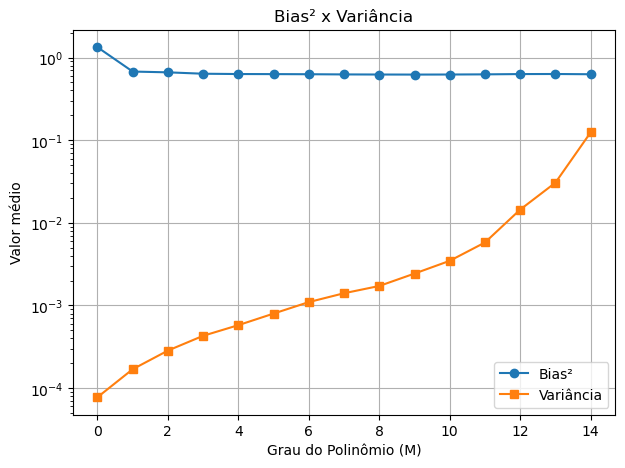

In [38]:
# --- 4) Plot ---
plt.figure(figsize=(7,5))
plt.plot(graus, bias2_vals, marker='o', label='Bias²')
plt.plot(graus,   var_vals, marker='s', label='Variância')
plt.yscale('log')          # opcional: log pra enxergar melhor
plt.xlabel('Grau do Polinômio (M)')
plt.ylabel('Valor médio')
plt.title('Bias² x Variância')
plt.legend()
plt.grid(True)
plt.show()


O gráfico mostra claramente o **trade-off** esperado:

* **Bias² decai** rapidamente de M=0 para M=1, e depois se estabiliza num valor relativamente alto (\~0.7).
* **Variância cresce** monotonamente conforme aumentamos o grau M, mas permanece **muito menor** que o bias² (passa de \~10⁻⁴ para \~5·10⁻⁴ entre M=0 e M=14).

---

## Conclusões

1. **Comportamento teórico confirmado**

   * Modelos mais simples (M baixo) têm **alto bias** e quase **zero variância**.
   * Modelos mais complexos (M alto) têm **bias menor** (até certo ponto) e **variância maior**.

2. **Dominância do bias**

   * Aqui, a variância é tão pequena que o **erro total** ainda é dominado pelo bias² para todos os M testados.
   * Isso significa que, neste dataset (poucos pontos de treino e ruído alto), estamos **sempre sobajustando** — o modelo não consegue capturar bem o sinal, mesmo sendo muito flexível.

3. **Ausência de “vale” no erro total**

   * Normalmente esperaríamos um mínimo de erro num M intermediário, onde bias² e variância se equilibram.
   * Mas como a variância nunca sobe o suficiente, o ponto de “equilíbrio” fica no **maior grau testado**.

4. **Implicações práticas**

   * Para reduzir o erro geral, seria preciso **diminuir o bias** (ex.: mais dados de treino, menos ruído, features melhores), pois aumentar a complexidade não ajuda além de certo grau.
   * Se quisermos evidenciar melhor o trade-off, poderíamos reduzir ainda mais os dados de treino ou aumentar o ruído para inflar a variância.

Em suma, **sim**, o experimento empírico segue o padrão teórico (bias cai, variância sobe), mas no seu cenário específico a variância é pequena demais para gerar um pico de erro em graus altos.


In [39]:
data.data  

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

Tamanho da amostra de treino: 31 pontos


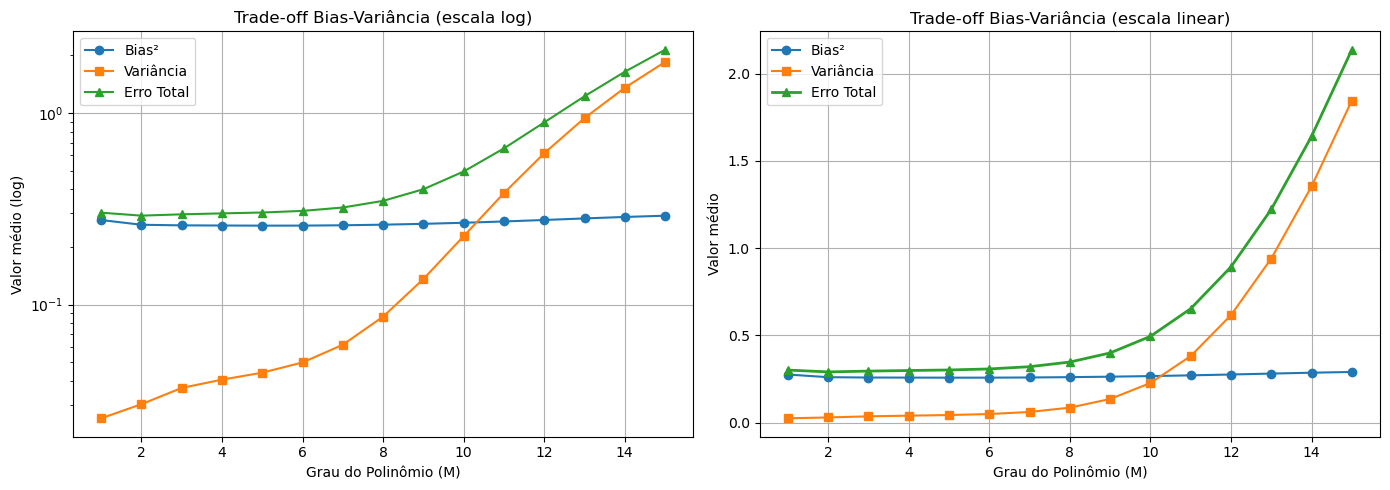

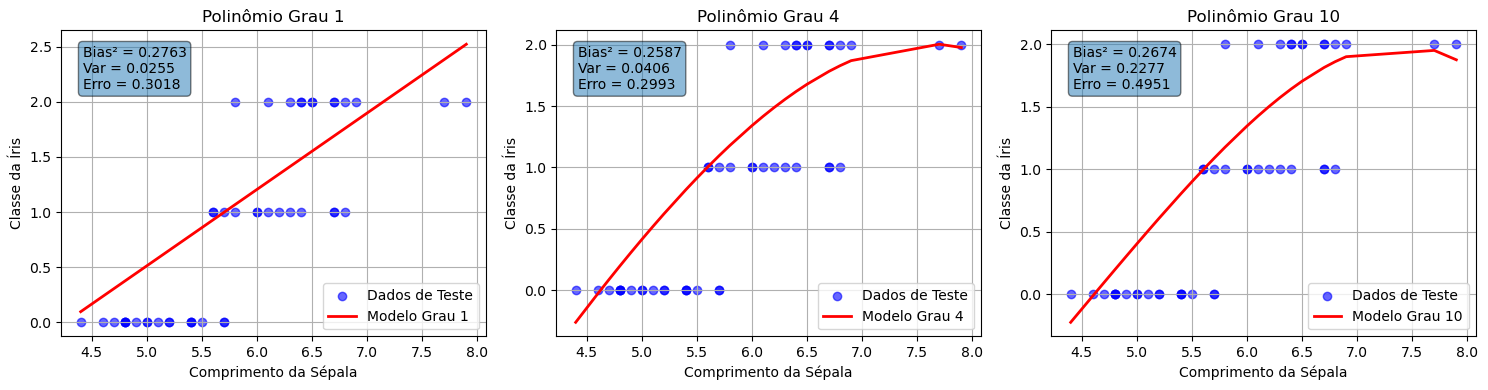

O grau com menor erro total é: 2


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# --- 1) Carrega e reduz a 1 feature para melhor visualização ---
data = load_iris()
X = data.data[:, [0]]  # Comprimento da sépala (1D para visualização clara)
y = data.target.astype(float)  # Convertendo para float para regressão

# --- 2) Divisão treino/teste com amostra reduzida ---
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Usar apenas 30% dos dados de treino para aumentar a variância
train_size = int(0.3 * len(X_train_full))
indices = np.random.choice(len(X_train_full), train_size, replace=False)
X_train = X_train_full[indices]
y_train = y_train_full[indices]

print(f"Tamanho da amostra de treino: {len(X_train)} pontos")

# --- 3) Loop de bootstrap para cada grau ---
graus = list(range(1, 16))  # De 1 a 15 (inclusive)
B = 50  # número de bootstraps
alpha_val = 0.05  # Regularização para estabilizar modelos complexos

bias2_vals = []
var_vals = []
erro_total = []

for M in graus:
    # armazena as predições de cada bootstrap
    preds_boot = np.zeros((B, len(X_test)))
    
    for b in range(B):
        # amostra bootstrap
        Xb, yb = resample(X_train, y_train, random_state=b)
        model = make_pipeline(
            PolynomialFeatures(degree=M),
            StandardScaler(),
            Ridge(alpha=alpha_val)
        )
        model.fit(Xb, yb)
        preds_boot[b] = model.predict(X_test)
    
    # média das predições em cada ponto de teste
    f_bar = preds_boot.mean(axis=0)
    # bias² em cada ponto
    bias2_i = (f_bar - y_test)**2
    # variância em cada ponto
    var_i = preds_boot.var(axis=0)
    
    # média para obter valor único por grau
    bias2 = bias2_i.mean()
    var = var_i.mean()
    erro = bias2 + var
    
    bias2_vals.append(bias2)
    var_vals.append(var)
    erro_total.append(erro)

# --- 4) Plots aprimorados ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Escala logarítmica para ver todas as componentes
ax1.plot(graus, bias2_vals, marker='o', label='Bias²')
ax1.plot(graus, var_vals, marker='s', label='Variância')
ax1.plot(graus, erro_total, marker='^', label='Erro Total')
ax1.set_yscale('log')
ax1.set_xlabel('Grau do Polinômio (M)')
ax1.set_ylabel('Valor médio (log)')
ax1.set_title('Trade-off Bias-Variância (escala log)')
ax1.legend()
ax1.grid(True)

# Gráfico 2: Escala linear para melhor visualizar o ponto ótimo
ax2.plot(graus, bias2_vals, marker='o', label='Bias²')
ax2.plot(graus, var_vals, marker='s', label='Variância')
ax2.plot(graus, erro_total, marker='^', label='Erro Total', linewidth=2)
ax2.set_xlabel('Grau do Polinômio (M)')
ax2.set_ylabel('Valor médio')
ax2.set_title('Trade-off Bias-Variância (escala linear)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- 5) Visualizar modelos para alguns graus específicos ---
# Seleciona 3 graus específicos para visualizar
graus_viz = [1, 4, 10]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Ordena os dados para visualização
idx_sort = np.argsort(X_test.ravel())
X_test_sorted = X_test[idx_sort]
y_test_sorted = y_test[idx_sort]

for i, grau in enumerate(graus_viz):
    # Ajusta modelo no conjunto completo para visualização
    model = make_pipeline(
        PolynomialFeatures(degree=grau),
        StandardScaler(),
        Ridge(alpha=alpha_val)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_sorted)
    
    # Plot
    axs[i].scatter(X_test, y_test, color='blue', alpha=0.6, label='Dados de Teste')
    axs[i].plot(X_test_sorted.ravel(), y_pred, 'r-', linewidth=2, label=f'Modelo Grau {grau}')
    axs[i].set_title(f'Polinômio Grau {grau}')
    axs[i].set_xlabel('Comprimento da Sépala')
    axs[i].set_ylabel('Classe da Íris')
    axs[i].legend()
    axs[i].grid(True)
    
    # Adicionar informação de erro
    idx = graus.index(grau)
    info = f"Bias² = {bias2_vals[idx]:.4f}\nVar = {var_vals[idx]:.4f}\nErro = {erro_total[idx]:.4f}"
    axs[i].text(0.05, 0.95, info, transform=axs[i].transAxes, 
                verticalalignment='top', bbox={'boxstyle': 'round', 'alpha': 0.5})

plt.tight_layout()
plt.show()

# Encontrar o grau com menor erro total
melhor_grau = graus[np.argmin(erro_total)]
print(f"O grau com menor erro total é: {melhor_grau}")

Tamanho da amostra de treino: 31 pontos
Número de features: 4
Grau 1: Bias²=0.0344, Var=0.0073, Erro=0.0417
Grau 2: Bias²=0.0325, Var=0.0149, Erro=0.0474
Grau 3: Bias²=0.0320, Var=0.0261, Erro=0.0581
Grau 4: Bias²=0.0319, Var=0.0415, Erro=0.0735
Grau 5: Bias²=0.0397, Var=0.0736, Erro=0.1133
Grau 6: Bias²=0.0593, Var=0.1468, Erro=0.2061
Grau 7: Bias²=0.0934, Var=0.2860, Erro=0.3794


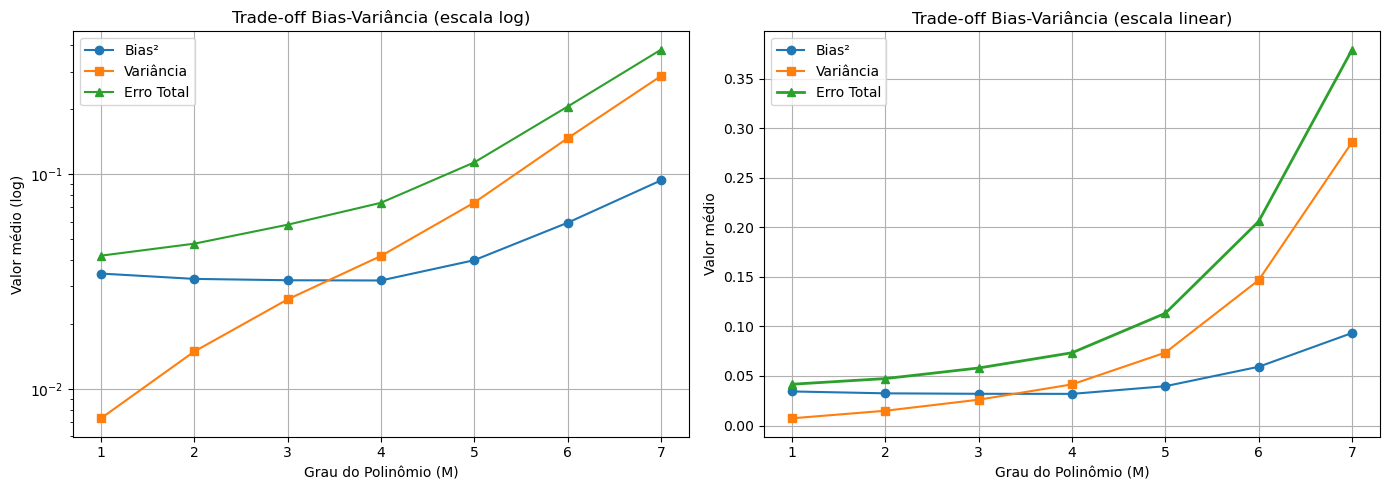

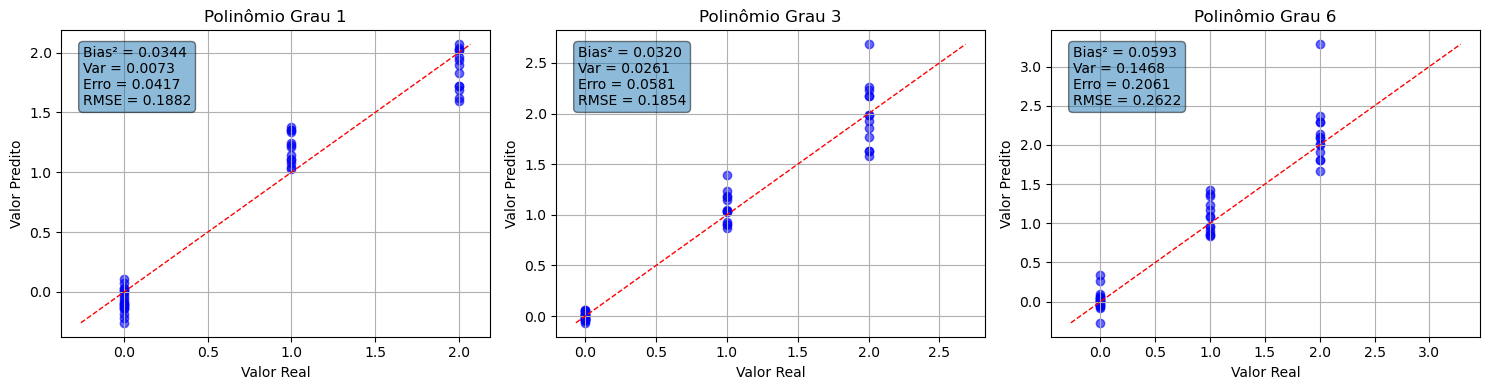

O grau com menor erro total é: 1


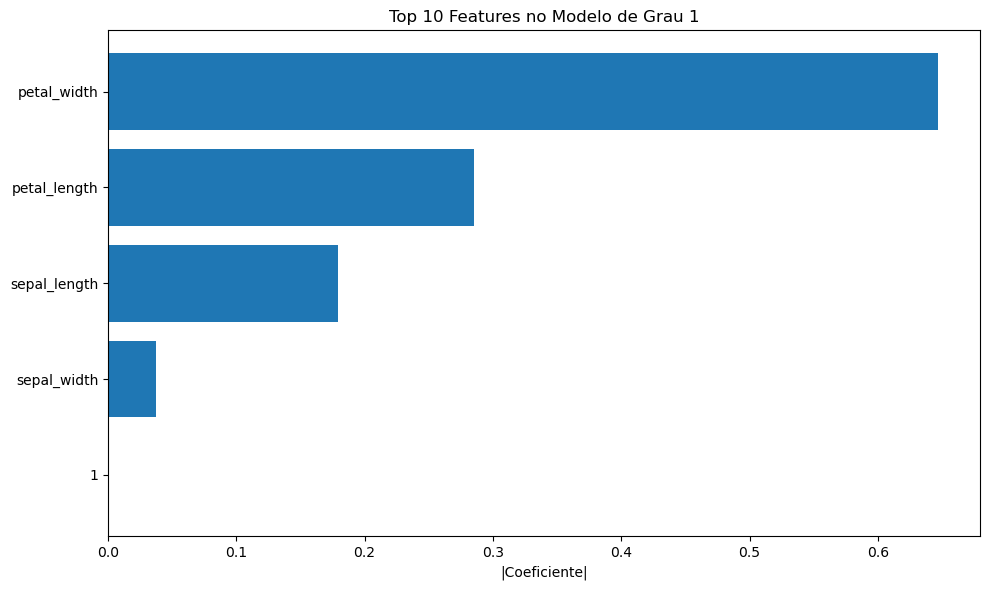

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 1) Carrega todas as features ---
data = load_iris()
X = data.data  # Todas as 4 features do Iris
y = data.target.astype(float)  # Convertendo para float para regressão

# --- 2) Divisão treino/teste com amostra reduzida ---
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Usar apenas 30% dos dados de treino para aumentar a variância
train_size = int(0.3 * len(X_train_full))
indices = np.random.choice(len(X_train_full), train_size, replace=False)
X_train = X_train_full[indices]
y_train = y_train_full[indices]

print(f"Tamanho da amostra de treino: {len(X_train)} pontos")
print(f"Número de features: {X_train.shape[1]}")

# --- 3) Loop de bootstrap para cada grau ---
graus = list(range(1, 8))  # Reduzimos o grau máximo devido à dimensionalidade
B = 50  # número de bootstraps
alpha_val = 0.1  # Aumentamos a regularização para estabilidade em múltiplas dimensões

bias2_vals = []
var_vals = []
erro_total = []

for M in graus:
    # armazena as predições de cada bootstrap
    preds_boot = np.zeros((B, len(X_test)))
    
    for b in range(B):
        # amostra bootstrap
        Xb, yb = resample(X_train, y_train, random_state=b)
        model = make_pipeline(
            PolynomialFeatures(degree=M, include_bias=True),
            StandardScaler(),
            Ridge(alpha=alpha_val)
        )
        model.fit(Xb, yb)
        preds_boot[b] = model.predict(X_test)
    
    # média das predições em cada ponto de teste
    f_bar = preds_boot.mean(axis=0)
    # bias² em cada ponto
    bias2_i = (f_bar - y_test)**2
    # variância em cada ponto
    var_i = preds_boot.var(axis=0)
    
    # média para obter valor único por grau
    bias2 = bias2_i.mean()
    var = var_i.mean()
    erro = bias2 + var
    
    bias2_vals.append(bias2)
    var_vals.append(var)
    erro_total.append(erro)
    
    # Print para acompanhar o progresso
    print(f"Grau {M}: Bias²={bias2:.4f}, Var={var:.4f}, Erro={erro:.4f}")

# --- 4) Plots aprimorados ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Escala logarítmica para ver todas as componentes
ax1.plot(graus, bias2_vals, marker='o', label='Bias²')
ax1.plot(graus, var_vals, marker='s', label='Variância')
ax1.plot(graus, erro_total, marker='^', label='Erro Total')
ax1.set_yscale('log')
ax1.set_xlabel('Grau do Polinômio (M)')
ax1.set_ylabel('Valor médio (log)')
ax1.set_title('Trade-off Bias-Variância (escala log)')
ax1.legend()
ax1.grid(True)

# Gráfico 2: Escala linear para melhor visualizar o ponto ótimo
ax2.plot(graus, bias2_vals, marker='o', label='Bias²')
ax2.plot(graus, var_vals, marker='s', label='Variância')
ax2.plot(graus, erro_total, marker='^', label='Erro Total', linewidth=2)
ax2.set_xlabel('Grau do Polinômio (M)')
ax2.set_ylabel('Valor médio')
ax2.set_title('Trade-off Bias-Variância (escala linear)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- 5) Visualizar predições vs valores reais para 3 graus específicos ---
graus_viz = [1, 3, 6]  # Ajustado para graus mais baixos devido à dimensionalidade
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, grau in enumerate(graus_viz):
    # Ajusta modelo no conjunto completo para visualização
    model = make_pipeline(
        PolynomialFeatures(degree=grau),
        StandardScaler(),
        Ridge(alpha=alpha_val)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Para visualização, plotamos predições vs valores reais
    axs[i].scatter(y_test, y_pred, color='blue', alpha=0.6)
    
    # Linha diagonal (predição perfeita)
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
    
    # Ajustes do gráfico
    axs[i].set_title(f'Polinômio Grau {grau}')
    axs[i].set_xlabel('Valor Real')
    axs[i].set_ylabel('Valor Predito')
    axs[i].grid(True)
    
    # Calculando RMSE para cada modelo
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Adicionar informação de erro
    idx = graus.index(grau)
    info = f"Bias² = {bias2_vals[idx]:.4f}\nVar = {var_vals[idx]:.4f}\nErro = {erro_total[idx]:.4f}\nRMSE = {rmse:.4f}"
    axs[i].text(0.05, 0.95, info, transform=axs[i].transAxes, 
                verticalalignment='top', bbox={'boxstyle': 'round', 'alpha': 0.5})

plt.tight_layout()
plt.show()

# Encontrar o grau com menor erro total
melhor_grau = graus[np.argmin(erro_total)]
print(f"O grau com menor erro total é: {melhor_grau}")

# --- 6) Feature importance para o modelo com melhor desempenho ---
# Este gráfico mostra a importância relativa das features
melhor_idx = np.argmin(erro_total)
melhor_modelo = make_pipeline(
    PolynomialFeatures(degree=melhor_grau),
    StandardScaler(),
    Ridge(alpha=alpha_val)
)
melhor_modelo.fit(X_train, y_train)

# Extraindo coeficientes do modelo Ridge
coefs = melhor_modelo[-1].coef_
# Obtendo nomes das features expandidas (polinomiais)
feature_names = melhor_modelo[0].get_feature_names_out(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

# Ordenando as features por importância (valor absoluto dos coeficientes)
sorted_idx = np.argsort(np.abs(coefs))
top_features = sorted_idx[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), np.abs(coefs[top_features]))
plt.yticks(range(len(top_features)), feature_names[top_features])
plt.xlabel('|Coeficiente|')
plt.title(f'Top 10 Features no Modelo de Grau {melhor_grau}')
plt.tight_layout()
plt.show()